# Model Evaluation: BERT Model

## Installing and Importing Relevant Libraries

In [ ]:
!pip install tensorflow-text==2.8.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import re

## Reading in Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Ml_course/Project/Data/processed_new.csv', 
                 usecols=['new_processed', 'Priority'] )
df.head()

,Priority,new_processed
0,High,claim assign hacker send message login page st...
1,High,log td check old charge able money cash money ...
2,High,hi receive email chime debit card send address...
3,High,allow fraudulent transaction notify email phon...
4,High,payment find scam want help reverse payment tr...


In [ ]:
df.isnull().sum()

Priority           0
new_processed    359
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.columns = ['label', 'text']

In [ ]:
df.head(3)

,label,text
0,High,claim assign hacker send message login page st...
1,High,log td check old charge able money cash money ...
2,High,hi receive email chime debit card send address...


## Splitting Data

In [ ]:
X = df['text']

In [ ]:
y = pd.get_dummies(df['label']).values

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, 
                                                              random_state=42, 
                                                              stratify=y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=y_train_full)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

## Converting to tensors

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
valid_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

## Modelling

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

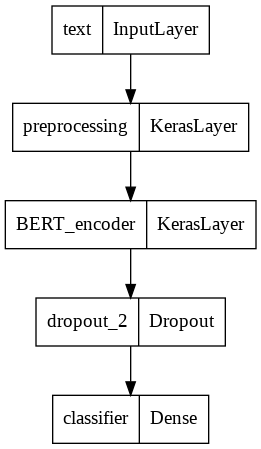

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=12, mode='min', 
                                              verbose=1)

In [ ]:
classifier_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [ ]:
bert_history = classifier_model.fit(train_data, 
                                    epochs=100, 
                                    callbacks=[early_stop], 
                                    validation_data=valid_data)

Epoch 1/100
1032/1032 [==============================] - 446s 425ms/step - loss: 1.0205 - accuracy: 0.4622 - val_loss: 0.9619 - val_accuracy: 0.5134
Epoch 2/100
1032/1032 [==============================] - 439s 425ms/step - loss: 0.9822 - accuracy: 0.5020 - val_loss: 0.9404 - val_accuracy: 0.5363
Epoch 3/100
1032/1032 [==============================] - 438s 425ms/step - loss: 0.9668 - accuracy: 0.5199 - val_loss: 0.9298 - val_accuracy: 0.5463
Epoch 4/100
1032/1032 [==============================] - 438s 424ms/step - loss: 0.9568 - accuracy: 0.5259 - val_loss: 0.9214 - val_accuracy: 0.5572
Epoch 5/100
1032/1032 [==============================] - 437s 424ms/step - loss: 0.9552 - accuracy: 0.5299 - val_loss: 0.9208 - val_accuracy: 0.5531
Epoch 6/100
1032/1032 [==============================] - 438s 424ms/step - loss: 0.9504 - accuracy: 0.5331 - val_loss: 0.9165 - val_accuracy: 0.5586
Epoch 7/100
1032/1032 [==============================] - 441s 427ms/step - loss: 0.9464 - accuracy: 0.5380

**Due to GPU limitations, the model could not be trained completely. The results remain inconclusive.**

*********************************